# Medical imaging segmentation


We analyze a set of 3D prostate magnetic resonance images. The main objective of this notebook is to segment them into 3 different areas: background (0), peripheral zone (1) and central gland (2).

The notebook is structured as follows:

1. Data Loading / Data Preprocessing
2. Define ConvNet Architecture
3. Define Loss Function / Evaluation Metrics
4. Training Pipeline
5. Results

In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
import random
from random import shuffle
import tensorflow as tf
import time
import os
import io
import datetime
import sklearn.metrics
import matplotlib.pyplot as plt
import itertools
import scipy.ndimage
import pandas as pd
import seaborn as sns
random.seed(42)
tf.random.set_seed(42)

In [2]:
%load_ext tensorboard

# 1. Data Loading / Data Preprocessing

In [43]:
def file_lists_to_slice_lists(input_files, labeling_files):
    """
    :param input_files: list of paths to input .npy images
    :param labeling_files: list of paths to .npy labels
    :return: sliced images, sliced one-hot encoded labels
    
    The images are stored as 3D objects. They are sliced to obtain 2D images.
    The output is shuffled to break up dependencies between adjacent slices.
    """

    inputs = []
    for in_file in input_files:
        sample = np.expand_dims(np.load(in_file).astype(np.float32), axis=3)
        if sample.shape[1] != 256 or sample.shape[2] != 256:
            print("Discarded input file ", in_file, " because it had dimensions ", sample.shape)
            continue
        sample -= np.mean(sample)
        sample /= np.std(sample)
        slices = np.vsplit(sample, sample.shape[0])
        for slice_id in range(sample.shape[0]):
            inputs.append(slices[slice_id][0])
                
    labelings = []
    for label_file in labeling_files:
        labeling = np.load(label_file)
        labeling[labeling == 3] = 1  # override erronous pixels
        if labeling.shape[1] != 256 or labeling.shape[2] != 256:
            print("Discarded labeling file ", label_file, " because it had dimensions ", labeling.shape)
            continue
        slices = np.vsplit(labeling, labeling.shape[0])
        for slice_id in range(labeling.shape[0]):
            m_slice = slices[slice_id][0]
            # turn to one-hot encoding / 3D tensor
            slice_onehot = np.zeros((m_slice.shape[0], m_slice.shape[1], 3))
            for class_idx in [0, 1, 2]:
                slice_onehot[:, :, class_idx][m_slice == class_idx] = 1               
            labelings.append(slice_onehot.astype(np.float32))
                                
    # shuffle after splicing, in order to break of dependencies between adjacent slices
    both = list(zip(inputs, labelings))
    shuffle(both)
    inputs, labelings = zip(*both)
    
    return np.array(inputs), np.array(labelings)


def load_data(image_path, label_path, num_val_subjects=5):
    """
    :param image_path: path to image data
    :param label_path: path to label data
    :param num_val_subjects: how many subjects to take as validation data. Default value of 5 ~ 10%
    :return: trainig set: tf.data.Dataset of images and labels, validation set
    
    Loads, splices and shuffles data (random rotation applied).
    """
    image_files = [join(image_path, f) for f in listdir(image_path)
                   if isfile(join(image_path, f)) and f.endswith("npy")]
    image_files.sort()

    label_files = [join(label_path, f) for f in listdir(label_path)
                   if isfile(join(label_path, f)) and f.endswith("npy")]
    label_files.sort()
    
    # split before augmentation and shuffling to get independent images from the training set!
    image_files_validation = image_files[0: num_val_subjects]
    label_files_validation = label_files[0: num_val_subjects]
    
    image_files = image_files[num_val_subjects: ]
    label_files = label_files[num_val_subjects: ]

    print("**** Generate training dataset ****")
    images, labels = file_lists_to_slice_lists(image_files, label_files)
    ds_images = tf.data.Dataset.from_tensor_slices(images)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    
    print("**** Generate validation dataset ****")
    images_validation,labels_validation = file_lists_to_slice_lists(image_files_validation, label_files_validation)
    ds_images_validation = tf.data.Dataset.from_tensor_slices(images_validation)
    ds_labels_validation = tf.data.Dataset.from_tensor_slices(labels_validation)

    return tf.data.Dataset.zip((ds_images, ds_labels)),  \
           tf.data.Dataset.zip((ds_images_validation, ds_labels_validation))

# 2. ConvNet Architecture

**U-Net** architecture has produced the best results in our experiments.

In [38]:
def make_unet_model(input_dims=(256, 256, 1)):
    img_input = tf.keras.Input(input_dims)
    drop_input = layers.Dropout(0.05)(img_input)
    
    conv1 = layers.Conv2D(8, 5, activation='relu', padding='same')(drop_input)
    conv1 = layers.Conv2D(8, 5, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=2, strides=2)(conv1)
    
    conv2 = layers.Conv2D(16, 5, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(16, 5, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=2, strides=2)(conv2)

    conv3 = layers.Conv2D(32, 5, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(32, 5, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=2, strides=2)(conv3)

    conv4 = layers.Conv2D(64, 5, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(64, 5, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=2, strides=2)(conv4)
    
    conv5 = layers.Conv2D(128, 5, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(128, 5, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(64, 5, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(64, 5, activation='relu', padding='same')(conv6)
    
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(32, 5, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(32, 5, activation='relu', padding='same')(conv7)
    
    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(32, 5, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(32, 5, activation='relu', padding='same')(conv8)
    
    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 5, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(32, 5, activation='relu', padding='same')(conv9)
    
    out = layers.Conv2D(3, 5, activation='linear', padding='same')(conv9) # output logits to improve stability

    model = tf.keras.Model(inputs=img_input, outputs=out)

    model.summary()

    return model


# 3. Loss Function / Evaluation Metrics

As we have demonstated in the *data_exploration.ipynb* notebook, one challenge is the severe class imbalance. To compensate for this we have decided to modify the loss function such that they could mitigate the effect of this imbalance.

### Custom Loss: Weighted Combination of WCE and Dice

In [16]:
def weighted_crossentropy(y_true_onehot, y_pred_logits, weighted=True):
    """
    :param true_labels: ground truth labels
    :param predicted_labels: model predicted labels
    :return: computed loss

    weighted categorical crossentropy loss
    
    if weighted = False, it is equivalent to:
    cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    return cross_entropy(true_labels, predicted_labels)
    """

    class_weights = tf.constant([[1., 1., 1.]])
    if weighted:
        class_weights = tf.constant([[0.9, 2.0, 1.0]])
    weights = tf.reduce_sum(class_weights * y_true_onehot, axis=-1)
    
    ce_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true_onehot), logits=y_pred_logits)
    weighted_loss = tf.reduce_mean(ce_loss * weights)
    return weighted_loss


def dice_loss(y_true_onehot, y_pred_logits, smooth=1e-7):
    y_pred_sftmx = tf.nn.softmax(y_pred_logits, axis=3) 
    # ignore class 0 (background): this gives us extra gradients on class-1 and class-2 kernel in the last layer
    y_pred_sftmx_crop = y_pred_sftmx[:, :, :, 1:]  
    y_true_onehot_crop = y_true_onehot[:, :, :, 1:]
    shape = y_true_onehot_crop.get_shape().as_list()
    dim = np.prod(shape[1:])  # dim = 256 x 256 x 3, exclude batch axis
    y_true_flat = tf.reshape(y_true_onehot_crop, [-1, dim])
    y_pred_flat = tf.reshape(y_pred_sftmx_crop, [-1, dim])    
    
    intersect = tf.reduce_sum(y_true_flat * y_pred_flat, axis=-1)
    denom = tf.reduce_sum(y_true_flat + y_pred_flat, axis=-1)
    return 1.0 - tf.reduce_mean((2. * intersect / (denom + smooth)))


def combined_loss(y_true_onehot, y_pred_logits):
    return 0.2 * weighted_crossentropy(y_true_onehot, y_pred_logits) + 0.8 * dice_loss(y_true_onehot, y_pred_logits)

### Evaluation Metrics

As instructed in the project description, our models are evaluated using three metrics: **Overall Precision (OP)**, **Per-Class Precision (PC)** and **Intersection over Union (IoU)**.

In [17]:
# metrics implementation
def compute_overall_precision(true_labels, predicted_labels):
    # Overall precision metric OP
    categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
    return categorical_accuracy(true_labels, predicted_labels)

def compute_per_class_precision(true_labels, predicted_labels):
    # Per class precision PC   
    predicted_labels = tf.keras.activations.softmax(predicted_labels)
    p0 = tf.keras.metrics.Precision(class_id=0)(true_labels, predicted_labels)
    p1 = tf.keras.metrics.Precision(class_id=1)(true_labels, predicted_labels)
    p2 = tf.keras.metrics.Precision(class_id=2)(true_labels, predicted_labels)
    return tf.math.reduce_sum((p0 + p1 + p2) / 3.0)

def compute_intersection_over_union(true_labels, predicted_labels):
    # Intersection over Union: first computes for each class, then averages
    true_labels = tf.reshape(tf.argmax(true_labels, axis=-1), shape=(-1, 1))
    predicted_labels = tf.reshape(tf.argmax(predicted_labels, axis=-1), shape=(-1, 1))
    iou = tf.keras.metrics.MeanIoU(num_classes=3)
    return iou(true_labels, predicted_labels)

### Simple Verification of our Implementation:

In [18]:
# check metrics implementation used in compute_metrics()
eps = 0.00001

t1 = tf.constant([[1., 0, 0], [0, 1, 0], [0, 0, 1]]) # true 0 1 2 
t1_p = tf.constant([[1., 0, 0], [0, 1, 0], [0, 0, 1]]) # predicted 0 1 2

t2 = t1 # true 0 1 2
t2_p = tf.constant([[5., -2, 2], [-2, -1, -5], [1, 3, 4]]) # predicted 0 1 2

t3 = t1 # true 0 1 2
t3_p = tf.constant([[2., 5, 2], [2, 3, 0], [1, 3, 4]]) # predicted 1 1 2

t4 = tf.constant([[1., 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]]) # true 0 1 2 2
t4_p = tf.constant([[1., 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0]]) # predicted 0 1 2 1

# OP
assert compute_overall_precision(t1, t1_p).numpy()  == 1
assert compute_overall_precision(t2, t2_p).numpy()  == 1
assert abs(compute_overall_precision(t3, t3_p).numpy() - 2. / 3) < eps
assert abs(compute_overall_precision(t4, t4_p).numpy() - 3. / 4) < eps

# PC
assert compute_per_class_precision(t1, t1_p).numpy()  == 1
assert compute_per_class_precision(t2, t2_p).numpy()  == 1
assert abs(compute_per_class_precision(t3, t3_p).numpy() - (0. + 0.5 + 1.) / 3) < eps
assert abs(compute_per_class_precision(t4, t4_p).numpy() - (1. + 1. + 0.5) / 3) < eps

# IoU
assert compute_intersection_over_union(t1, t1_p).numpy()  == 1
assert compute_intersection_over_union(t2, t2_p).numpy()  == 1
assert abs(compute_intersection_over_union(t3, t3_p).numpy() - (0. + 0.5 + 1.) / 3) < eps
assert abs(compute_intersection_over_union(t4, t4_p).numpy() - (1. + 0.5 + 0.5) / 3) < eps

# 4. Training Pipeline
### Plotting training progress

In order to evaluate the quality of our models, we plot a random set of images from the eval set after each epoch during training. Below are a few helper functions. Use **Tensorboard** in order to see live outputs (images as well as scalar metrics).

In [19]:
def plot_to_image(figure, expand=True):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    
    modifed from: www.tensorflow.org/tensorboard/image_summaries
    """
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    if expand:
        image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names, normalize = False):
    """
    :param cm (array, shape = [n, n]): a confusion matrix of integer classes
    :param class_names (array, shape = [n]): String names of the integer classes
    "return matplotlib figure containing the plotted confusion matrix.
  
    modified from: www.tensorflow.org/tensorboard/image_summaries
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure


def plot_true_vs_output_images(true_images, output_images):
    # Plots true and predicted images.
    figure = plt.figure(figsize=(8,8))
    
    for pair in range(0,8):
        plt.subplot(4, 4, pair * 2 + 1, title="Ground truth {}".format(pair), frameon=False)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(true_images[pair])

        plt.subplot(4, 4, pair * 2 + 2, title="Predicted {}".format(pair), frameon=False)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(output_images[pair])
 
    plt.tight_layout()
    return figure

## Data Augmentation

We augment our dataset by introducing random rotations. This ensures that our trained model will be equivariant under rotation.

In [20]:
# dataset augmentation
def rotate_image(image, angle):
    image = scipy.ndimage.rotate(image, angle, reshape=False, mode='nearest', order=0)
    return image

def produce_random_angle():
    new_angle = random.randint(0, 360)
    while abs(new_angle - produce_random_angle.old_angle) <= 10:
        new_angle = random.randint(0, 360)
    produce_random_angle.old_angle = new_angle
    return new_angle
    
produce_random_angle.old_angle = random.randint(0, 360)  # this line HAS to run once (before training starts)

def tf_random_rotate_image(image, label):
    # return several randomly rotated versions of input arguments
    rot_images, rot_labels = [], []
    for _ in range(3):
        angle = produce_random_angle()
    
        [rot_image,] = tf.py_function(rotate_image, [image, angle], [tf.float32])
        rot_image.set_shape(image.shape)
        rot_images.append(rot_image)

        [rot_label,] = tf.py_function(rotate_image, [label, angle], [tf.float32])
        rot_label.set_shape(label.shape)
        rot_labels.append(rot_label)
    
    return tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(rot_images),
                                tf.data.Dataset.from_tensor_slices(rot_labels)))

### Helper function to compute metrics during training:

In [21]:
def compute_metrics(labels, predicted_labels, loss_metric, acc_metric, perclass_prec_metrics, iou_metric):
    # mean loss for all examples
    loss = combined_loss(labels, predicted_labels)
    loss_metric.update_state(loss)
    # OP
    acc_metric.update_state(labels, predicted_labels)
    # PC
    prec_predicted_labels = tf.keras.activations.softmax(predicted_labels)
    perclass_prec_metrics[0].update_state(labels, prec_predicted_labels)
    perclass_prec_metrics[1].update_state(labels, prec_predicted_labels)
    perclass_prec_metrics[2].update_state(labels, prec_predicted_labels)
    # IoU
    iou_labels = tf.reshape(tf.argmax(labels, axis=-1), shape=(-1, 1))
    iou_predicted_labels = tf.reshape(tf.argmax(predicted_labels, axis=-1), shape=(-1, 1))
    iou_metric.update_state(iou_labels, iou_predicted_labels)

## Full Training Procedure
Define a few constants for training:

In [44]:
class Arguments:
    # model naming
    version = None # model version

    # hyper parameters
    epochs = 30 # number of epochs to train the model
    batch_size = 32 # nr of images per batch

    # model settings
    buffer_size = 256 # buffer size for shuffling
    img_width = 256 # image width
    img_height = 256 # image height

    # paths
    train_image_path = '../input/train_images/'
    train_label_path ='../input/train_labels/'
    test_image_path = '../input/test_images/'
    test_label_path = '../input/test_labels/'
    rot_test_image_path = '../input/test_images_randomly_rotated/'
    rot_test_label_path = '../input/test_labels_randomly_rotated/'
    checkpoint_dir = 'checkpoints/'
    logs_dir ='logs/'
    
args = Arguments()
args.version = 'v45'

Below live training results can be monitored.  
Please change the tab to "IMAGES" and tick "Show actual image size" in order to see the current output.

In [ ]:
%tensorboard --logdir {args.logs_dir + args.version}

### Train function:

In [45]:
def train(train_dataset_pre, validation_dataset_pre, epochs, batch_size,  buffer_size, model, optimizer,\
          manager, checkpoint, summary_writer, summary_writer_val):
    
    loss_metric = tf.keras.metrics.Mean(name='Loss')
    acc_metric = tf.keras.metrics.CategoricalAccuracy(name='Categorical accuracy')
    
    perclass_prec_metrics = [tf.keras.metrics.Precision(class_id=0, name='Per class 0 precision'),
                             tf.keras.metrics.Precision(class_id=1, name='Per class 1 precision'),
                             tf.keras.metrics.Precision(class_id=2, name='Per class 2 precision')]
    
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=3, name='Intersection over Union')
    
    val_loss_metric = tf.keras.metrics.Mean(name='Validation: Loss')
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='Validation: Categorical accuracy')
    
    val_perclass_prec_metrics = [tf.keras.metrics.Precision(class_id=0, name='Validation: Per class 0 precision'),
                                 tf.keras.metrics.Precision(class_id=1, name='Validation: Per class 1 precision'),
                                 tf.keras.metrics.Precision(class_id=2, name='Validation: Per class 2 precision')]
    
    val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=3, name='Validation: Intersection over Union')
    

    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored model from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    epochs_so_far = checkpoint.step
    epochs = epochs + epochs_so_far

    for epoch in tf.range(epochs_so_far, epochs):
        
        train_dataset = train_dataset_pre.flat_map(tf_random_rotate_image).shuffle(buffer_size).batch(batch_size)
        validation_dataset = validation_dataset_pre.flat_map(tf_random_rotate_image).shuffle(buffer_size).batch(batch_size)
        
        start = time.time()

        for image_batch, labels in train_dataset:
            with tf.GradientTape() as grad_tape:
                predicted_logits = model(image_batch)
                loss = combined_loss(labels, predicted_logits)
                gradients = grad_tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
            compute_metrics(labels, predicted_logits, loss_metric, acc_metric, perclass_prec_metrics, iou_metric)
        
        for image_batch, labels in validation_dataset:
            predicted_logits = model(image_batch, training=False)
            compute_metrics(labels, predicted_logits, val_loss_metric, val_acc_metric, \
                            val_perclass_prec_metrics, val_iou_metric)
                        
            
        # take 8 random images from validation set
        # compute one batch confusion matrix
        # add .shuffle(buffer_size) to get something slightly different reach run
        for image_batch, labels in validation_dataset.shuffle(4).take(1): 
            output = model(image_batch, training=False)
            
            true_labels_flat = tf.reshape(tf.argmax(labels, axis=-1), shape=(-1, 1))
            predicted_labels_flat = tf.reshape(tf.argmax(output, axis=-1), shape=(-1, 1))
            # confusion matrix per one batch
            cm = sklearn.metrics.confusion_matrix(true_labels_flat, predicted_labels_flat)
            figure = plot_confusion_matrix(cm, class_names=[0, 1, 2])
            cm_image = plot_to_image(figure)
            # pick 8 images
            output_image = output[:8]
            true_image = labels[:8]
            # to one hot encoding from logits
            output_image = tf.argmax(output_image, axis=-1)
            output_image = tf.one_hot(output_image, 3)
            
            image_comparison = plot_to_image(plot_true_vs_output_images(true_image, output_image))

        # Generate summaries   
        with summary_writer.as_default():
            tf.summary.scalar(name='weighted cross-entropy loss', data=loss_metric.result(), step=epoch)
            tf.summary.scalar(name='OP overall precision', data=acc_metric.result(), step=epoch)
            
            PC = (perclass_prec_metrics[0].result() + perclass_prec_metrics[1].result() \
                  + perclass_prec_metrics[2].result())/3.0
            tf.summary.scalar(name='PC per class precision', data=PC, step=epoch)
                              
            tf.summary.scalar(name='IoU intersection over union', data=iou_metric.result(), step=epoch)
        with summary_writer_val.as_default():
            tf.summary.scalar(name='weighted cross-entropy loss', data=val_loss_metric.result(), step=epoch)
            tf.summary.scalar(name='OP overall precision', data=val_acc_metric.result(), step=epoch)
                              
            val_PC = (val_perclass_prec_metrics[0].result() + val_perclass_prec_metrics[1].result() \
                  + val_perclass_prec_metrics[2].result())/3.0                 
            tf.summary.scalar(name='PC per class precision', data=val_PC, step=epoch)
                              
            tf.summary.scalar(name='IoU intersection over union', data=val_iou_metric.result(), step=epoch)
            tf.summary.image(name='true vs predicted image',  data=image_comparison, step=epoch)
            tf.summary.image("val batch confusion matrix", cm_image, step=epoch)

        print("************************")
        print("Epoch {}".format(epoch))  
        print("Validation set metrics")
        print("Loss value:")
        print(val_loss_metric.result().numpy())
        print("Overall precision:")
        print(val_acc_metric.result().numpy())
        print("Per class precision:")
        print(val_PC.numpy())
        print("Intersection over Union:")
        print(val_iou_metric.result().numpy())

        checkpoint.step.assign_add(1)
        manager.save()

        loss_metric.reset_states()
        acc_metric.reset_states()
        perclass_prec_metrics[0].reset_states()
        perclass_prec_metrics[1].reset_states()
        perclass_prec_metrics[2].reset_states()
        iou_metric.reset_states()
        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        val_perclass_prec_metrics[0].reset_states()
        val_perclass_prec_metrics[1].reset_states()
        val_perclass_prec_metrics[2].reset_states()
        val_iou_metric.reset_states()
        
        print('Time for epoch {} is {} sec'.format(epoch, time.time() - start))

## Build dataset, model, optimizers and loggers:

In [46]:
train_dataset_pre, validation_dataset_pre = load_data(args.train_image_path, args.train_label_path)

# build u-net
unet_model = make_unet_model((args.img_width, args.img_height, 1))
# optimizer
unet_optimizer = tf.keras.optimizers.Adam(1.5e-4)
# define checkpoint
checkpoint_dir = os.path.join(args.checkpoint_dir, args.version)
checkpoint = tf.train.Checkpoint(step=tf.Variable(0, dtype=tf.int64),
                                 unet_optimizer=unet_optimizer,
                                 unet_model=unet_model)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=100)
# set up summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = args.logs_dir + args.version + '/' + current_time
summary_writer = tf.summary.create_file_writer(log_dir + "/training")
summary_writer_val = tf.summary.create_file_writer(log_dir + "/validation")

**** Generate training dataset ****
Discarded input file  ../input/train_images/sample-43.npy  because it had dimensions  (18, 80, 80, 1)
Discarded labeling file  ../input/train_labels/sample-43.npy  because it had dimensions  (18, 80, 80)
**** Generate validation dataset ****
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 256, 256, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 8)  208         dropout_4[0][0]                  
____________

### Start the actual training:

In [47]:
train(train_dataset_pre, validation_dataset_pre, args.epochs, args.batch_size, args.buffer_size,\
      unet_model, unet_optimizer,\
      manager, checkpoint, summary_writer, summary_writer_val)

Initializing from scratch.
************************
Epoch 0
Validation set metrics
Loss value:
0.5923264
Overall precision:
0.91787916
Per class precision:
0.43736336
Intersection over Union:
0.41113153
Time for epoch 0 is 85.60209608078003 sec
************************
Epoch 1
Validation set metrics
Loss value:
0.52238595
Overall precision:
0.9482464
Per class precision:
0.58672065
Intersection over Union:
0.48444137
Time for epoch 1 is 85.03074669837952 sec
************************
Epoch 2
Validation set metrics
Loss value:
0.47306252
Overall precision:
0.96058995
Per class precision:
0.5296446
Intersection over Union:
0.49836874
Time for epoch 2 is 87.07512903213501 sec
************************
Epoch 3
Validation set metrics
Loss value:
0.49580127
Overall precision:
0.94889665
Per class precision:
0.49339882
Intersection over Union:
0.46971193
Time for epoch 3 is 86.86335635185242 sec
************************
Epoch 4
Validation set metrics
Loss value:
0.5660398
Overall precision:
0.9

# 5. Final model evaluation
First we load the test data, using basically the same code as for the train set:

In [48]:
def load_test_data(image_path, label_path):
    """
    :param image_path: path to image data
    :param label_path: path to label data
    :return: trainig set: tf.data.Dataset of images and labels
    
    Loads, splices the test dataset.
    """
    image_files = [join(image_path, f) for f in listdir(image_path)
                   if isfile(join(image_path, f)) and f.endswith("npy")]
    image_files.sort()

    label_files = [join(label_path, f) for f in listdir(label_path)
                   if isfile(join(label_path, f)) and f.endswith("npy")]
    label_files.sort()

    print("**** Generate test dataset ****")
    images, labels = file_lists_to_slice_lists(image_files, label_files)
    ds_images = tf.data.Dataset.from_tensor_slices(images)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)

    return tf.data.Dataset.zip((ds_images, ds_labels))

Then we restore the trained model and define test metrics:

In [49]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored model from {}".format(manager.latest_checkpoint))
else:
    print("No checkpoint available for evaluation!.")
    
test_loss_metric = tf.keras.metrics.Mean(name='Test: Loss')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='Test: Categorical accuracy')
    
test_perclass_prec_metrics = [tf.keras.metrics.Precision(class_id=0, name='Test: Per class 0 precision'),
                                 tf.keras.metrics.Precision(class_id=1, name='Test: Per class 1 precision'),
                                 tf.keras.metrics.Precision(class_id=2, name='Test: Per class 2 precision')]
    
test_iou_metric = tf.keras.metrics.MeanIoU(num_classes=3, name='Test: Intersection over Union')

Restored model from checkpoints/v45\ckpt-30


Finally, we predict both the original as well as the rotated version of the test data:

In [50]:
test_dataset = load_test_data(args.test_image_path, args.test_label_path).batch(args.batch_size)
rot_test_dataset = load_test_data(args.rot_test_image_path, args.rot_test_label_path).batch(args.batch_size)

for image_batch, labels in test_dataset:
    predicted_logits = unet_model(image_batch, training=False)
    compute_metrics(labels, predicted_logits, test_loss_metric,
                    test_acc_metric, test_perclass_prec_metrics, test_iou_metric)

OP = test_acc_metric.result().numpy()
PC = (test_perclass_prec_metrics[0].result() + test_perclass_prec_metrics[1].result() \
      + test_perclass_prec_metrics[2].result()).numpy() / 3.0  
IoU = test_iou_metric.result().numpy()

print("*********** Test data evaluation*************")
print("Overall precision:")
print(OP)
print("Per class precision:")
print(PC)
print("Intersection over Union:")
print(IoU)

**** Generate test dataset ****
**** Generate test dataset ****
*********** Test data evaluation*************
Overall precision:
0.9545633
Per class precision:
0.7191563447316488
Intersection over Union:
0.57141155


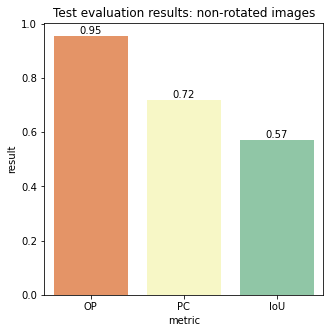

In [51]:
results = pd.DataFrame({"metric": ["OP", "PC",  "IoU"], "result": [OP, PC, IoU]})
plt.figure(figsize=(5, 5))
splot = sns.barplot(x="metric", y="result", data=results, palette="Spectral")
plt.title("Test evaluation results: non-rotated images")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [52]:
for image_batch, labels in rot_test_dataset:
    predicted_logits = unet_model(image_batch, training=False)
    compute_metrics(labels, predicted_logits, test_loss_metric,
                    test_acc_metric, test_perclass_prec_metrics, test_iou_metric)

OP = test_acc_metric.result().numpy()
PC = (test_perclass_prec_metrics[0].result() + test_perclass_prec_metrics[1].result() \
      + test_perclass_prec_metrics[2].result()).numpy() / 3.0  
IoU = test_iou_metric.result().numpy()

print("*********** Rotated Test data evaluation*************")
print("Overall precision:")
print(OP)
print("Per class precision:")
print(PC)
print("Intersection over Union:")
print(IoU)

*********** Rotated Test data evaluation*************
Overall precision:
0.95316356
Per class precision:
0.7245470682779948
Intersection over Union:
0.5663588


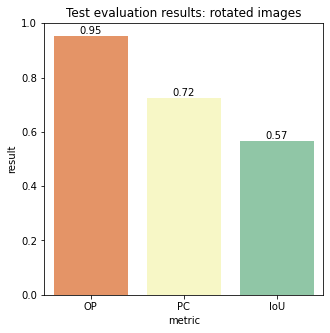

In [53]:
results = pd.DataFrame({"metric": ["OP", "PC",  "IoU"], "result": [OP, PC, IoU]})
plt.figure(figsize=(5, 5))
splot = sns.barplot(x="metric", y="result", data=results, palette="Spectral")
plt.title("Test evaluation results: rotated images")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

### Plot a few test predictions:

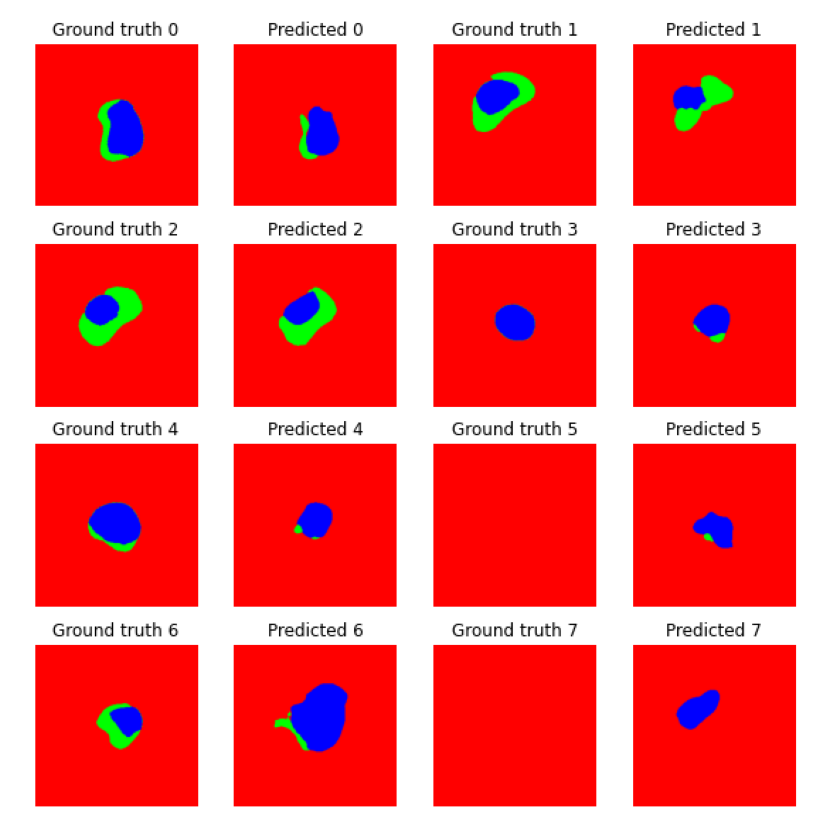

In [54]:
for image_batch, labels in rot_test_dataset.shuffle(4).take(1): 
    output = unet_model(image_batch, training=False)
    true_labels_flat = tf.reshape(tf.argmax(labels, axis=-1), shape=(-1, 1))
    predicted_labels_flat = tf.reshape(tf.argmax(output, axis=-1), shape=(-1, 1))
    # pick 8 images
    output_image = output[:8]
    true_image = labels[:8]
    # to one hot encoding from logits
    output_image = tf.argmax(output_image, axis=-1)
    output_image = tf.one_hot(output_image, 3)
    image_comparison = plot_to_image(plot_true_vs_output_images(true_image, output_image))
    # show plot
    plt.figure(figsize=(15, 15)) 
    plt.imshow(image_comparison[0])
    plt.axis('off')
    plt.show()